In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional, Attention, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [ ]:
def info(dataframe):
  print(100 * "_")
  print('DIMENSION: ({}, {})'.format(dataframe.shape[0], dataframe.shape[1]))
  print(100 * "_")
  print("COLUMNS:\n")
  print(dataframe.columns.values)
  print(100 * "_")
  print("DATA INFO:\n")
  print(dataframe.dtypes)
  print(100 * "_")
  print("MISSING VALUES:\n")
  print(dataframe.isnull().sum())
  print(100 * "_")
  print("NUMBER OF UNIQUE VALUES:\n")
  print(dataframe.nunique())
  print(100 * "_")
  print("UNIQUE VALUES:\n")
  columns = [column for column in dataframe.columns if dataframe[column].nunique() <= 10]
  for col in columns:
    print(f"{col}: {dataframe[col].unique()}")
  print(100 * "_")
  print("OCURRENCES:\n")
  columns = [column for column in dataframe.columns if dataframe[column].nunique() <= 10]
  for col in columns:
    print(f"{dataframe[col].value_counts()}")

# Load the data

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/test.csv')

# Data Preprocessing Function

In [ ]:
def preprocess_data(df):
    df['DATE'] = pd.to_datetime(df['DATE'], format='%d-%m-%Y')
    df['DAY_OF_YEAR'] = df['DATE'].dt.dayofyear
    df['MONTH'] = df['DATE'].dt.month
    df['YEAR'] = df['DATE'].dt.year

    df['DAY_OF_YEAR_SIN'] = np.sin(2 * np.pi * df['DAY_OF_YEAR'] / 365.25)
    df['DAY_OF_YEAR_COS'] = np.cos(2 * np.pi * df['DAY_OF_YEAR'] / 365.25)
    df['MONTH_SIN'] = np.sin(2 * np.pi * df['MONTH'] / 12)
    df['MONTH_COS'] = np.cos(2 * np.pi * df['MONTH'] / 12)

    for feature in ['LATITUDE', 'LONGITUDE', 'ELEVATION']:
        df[f'AVG_{feature}'] = df[[f'{feature}_A', f'{feature}_B', f'{feature}_C']].mean(axis=1)
        df[f'MAX_{feature}_DIFF'] = df[[f'{feature}_A', f'{feature}_B', f'{feature}_C']].max(axis=1) - df[[f'{feature}_A', f'{feature}_B', f'{feature}_C']].min(axis=1)

    weather_features = ['PRCP', 'SNWD', 'TMAX', 'TMIN', 'TAVG']
    for feature in weather_features:
        df[f'AVG_{feature}'] = df[[f'{feature}_A', f'{feature}_B', f'{feature}_C']].mean(axis=1)
        df[f'MIN_{feature}'] = df[[f'{feature}_A', f'{feature}_B', f'{feature}_C']].min(axis=1)
        df[f'MAX_{feature}'] = df[[f'{feature}_A', f'{feature}_B', f'{feature}_C']].max(axis=1)
        df[f'RANGE_{feature}'] = df[f'MAX_{feature}'] - df[f'MIN_{feature}']

    df['LAT_LON_INTERACTION'] = df['AVG_LATITUDE'] * df['AVG_LONGITUDE']
    df['ELEVATION_TEMP_INTERACTION'] = df['AVG_ELEVATION'] * df['AVG_TAVG']

    features = [
        'YEAR',
        'DAY_OF_YEAR_SIN', 'DAY_OF_YEAR_COS', 'MONTH_SIN', 'MONTH_COS',
        'ELEVATION_TEMP_INTERACTION',
        'AVG_TMAX', 'MIN_TMAX', 'MAX_TMAX', 'RANGE_TMAX',
        'AVG_TMIN', 'MIN_TMIN', 'MAX_TMIN', 'RANGE_TMIN',
        'AVG_TAVG', 'MIN_TAVG', 'MAX_TAVG', 'RANGE_TAVG'
    ]

    return df[features]


# Preprocess the data

In [ ]:
X = preprocess_data(train_data)
y = train_data['TAVG']

In [ ]:
info(X)

____________________________________________________________________________________________________
DIMENSION: (812, 18)
____________________________________________________________________________________________________
COLUMNS:

['YEAR' 'DAY_OF_YEAR_SIN' 'DAY_OF_YEAR_COS' 'MONTH_SIN' 'MONTH_COS'
 'ELEVATION_TEMP_INTERACTION' 'AVG_TMAX' 'MIN_TMAX' 'MAX_TMAX'
 'RANGE_TMAX' 'AVG_TMIN' 'MIN_TMIN' 'MAX_TMIN' 'RANGE_TMIN' 'AVG_TAVG'
 'MIN_TAVG' 'MAX_TAVG' 'RANGE_TAVG']
____________________________________________________________________________________________________
DATA INFO:

YEAR                            int32
DAY_OF_YEAR_SIN               float64
DAY_OF_YEAR_COS               float64
MONTH_SIN                     float64
MONTH_COS                     float64
ELEVATION_TEMP_INTERACTION    float64
AVG_TMAX                      float64
MIN_TMAX                      float64
MAX_TMAX                      float64
RANGE_TMAX                    float64
AVG_TMIN                      float

# Data Visualization

In [ ]:
def plot_scatter():
  for i in X.columns:
      plt.scatter(x=X[i],y=y)
      plt.xlabel(i)
      plt.ylabel('TAVG')
      plt.show()

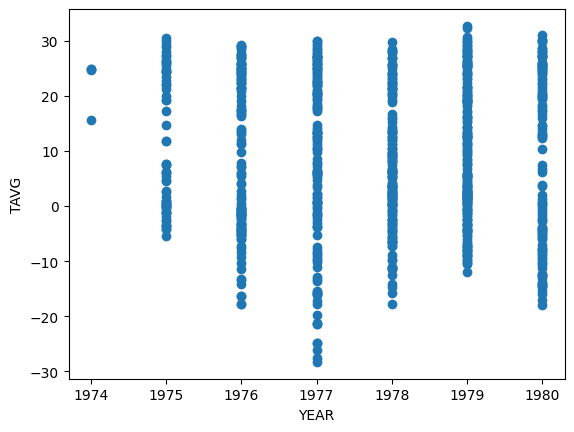

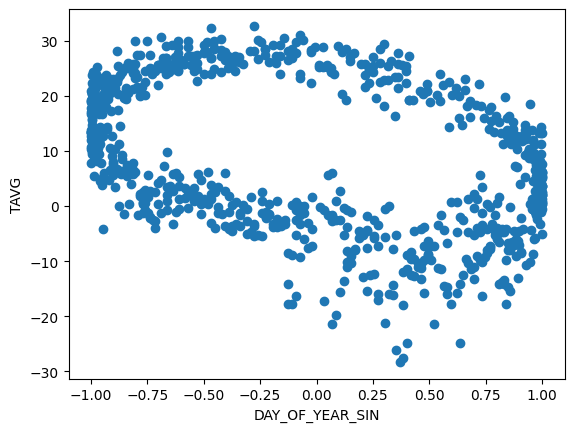

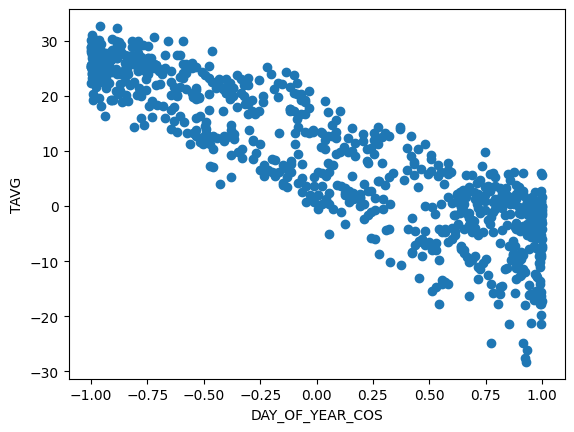

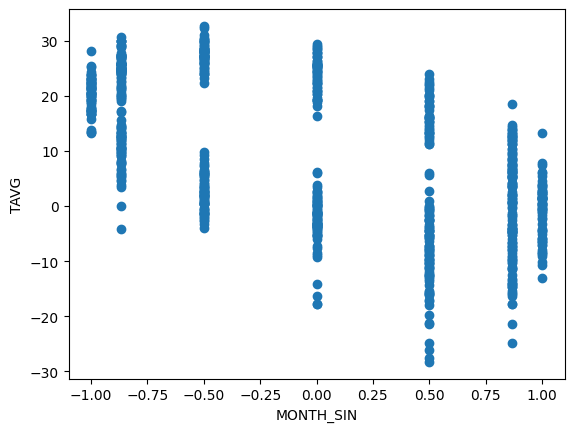

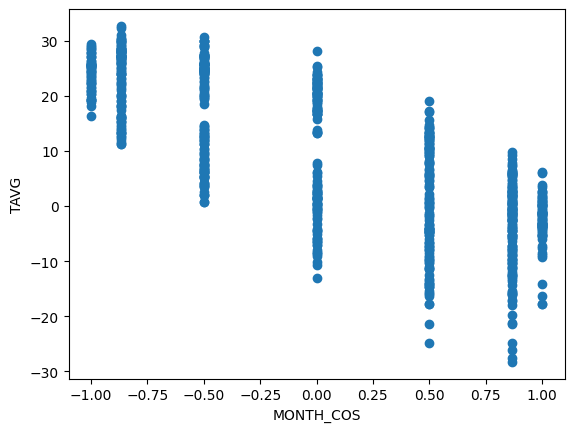

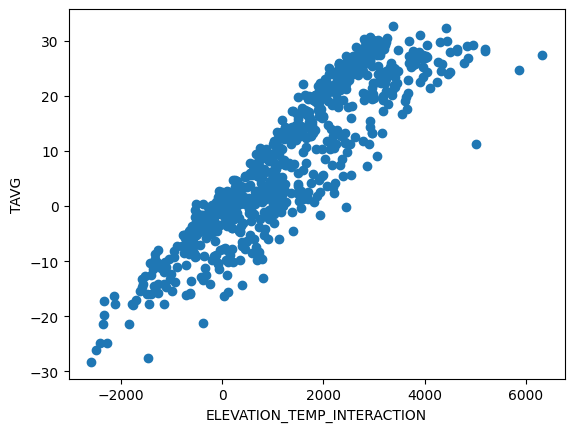

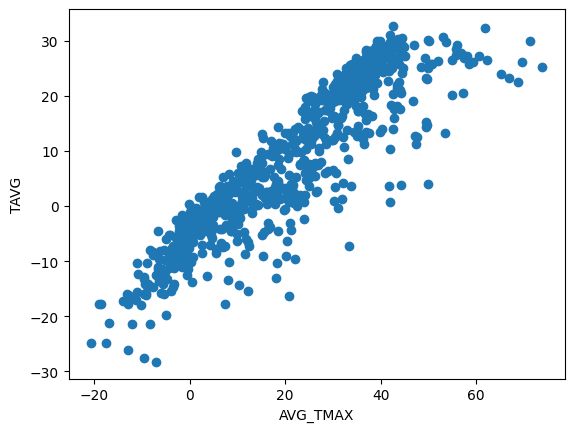

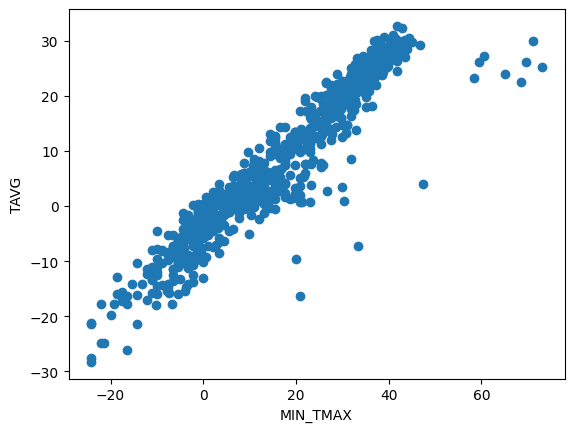

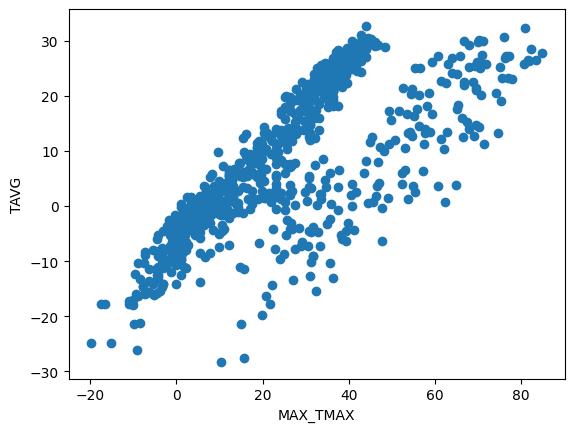

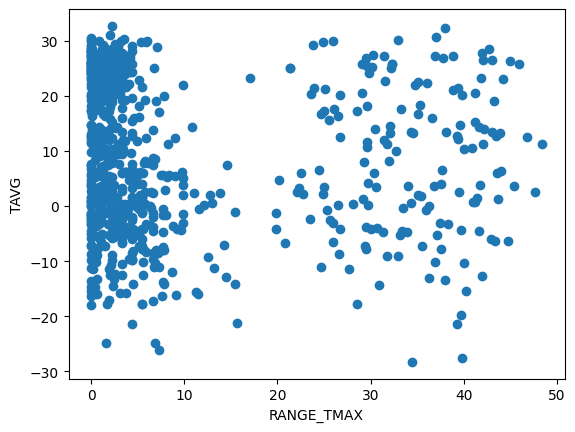

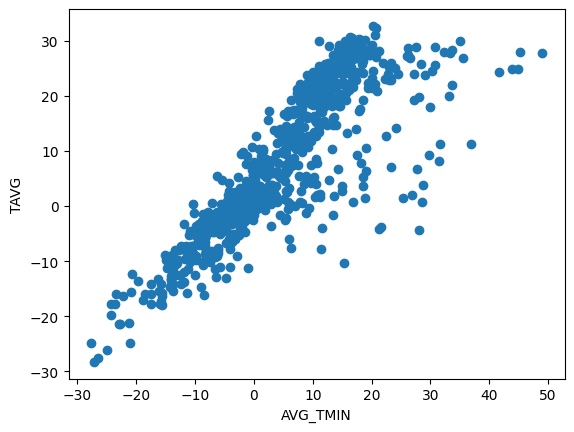

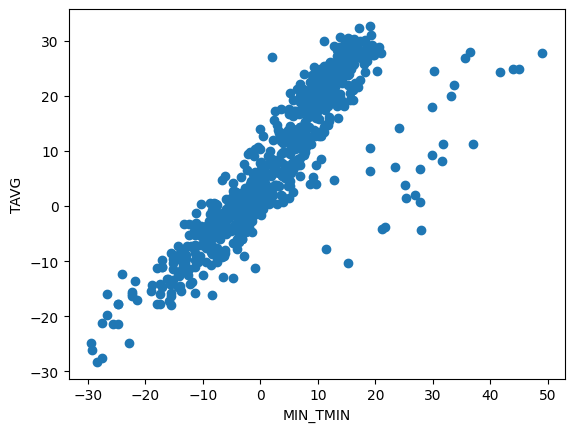

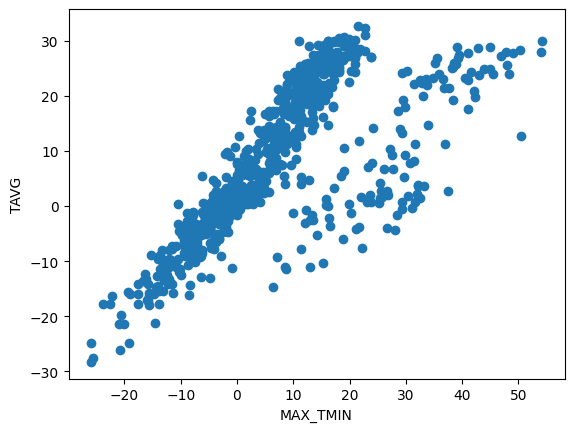

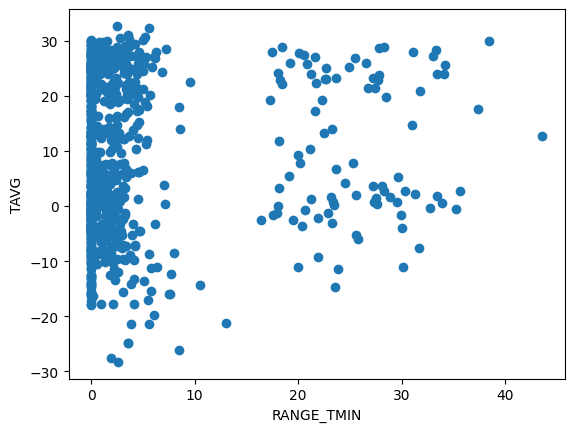

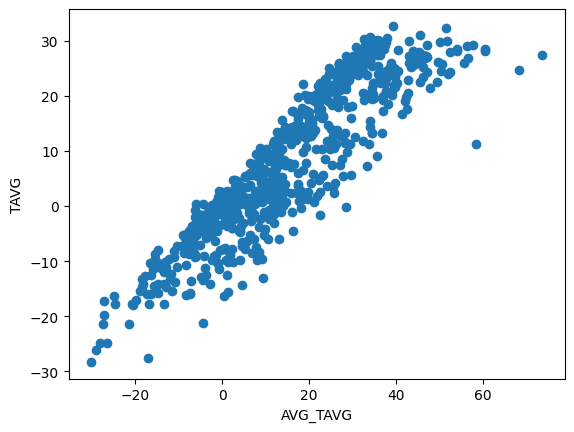

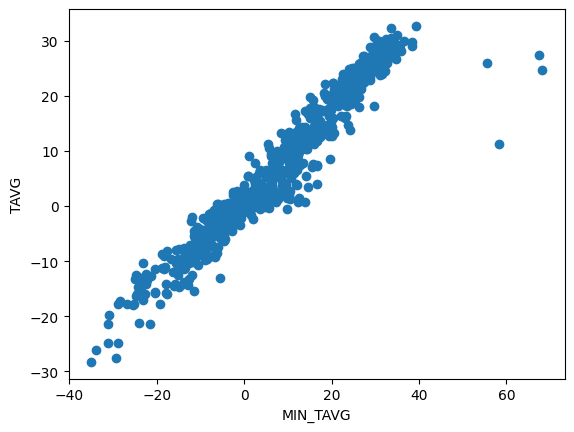

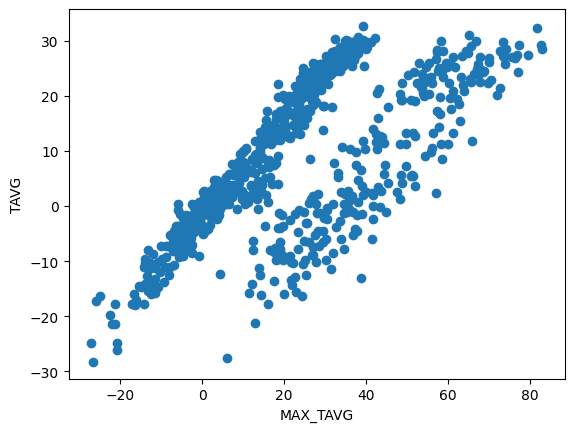

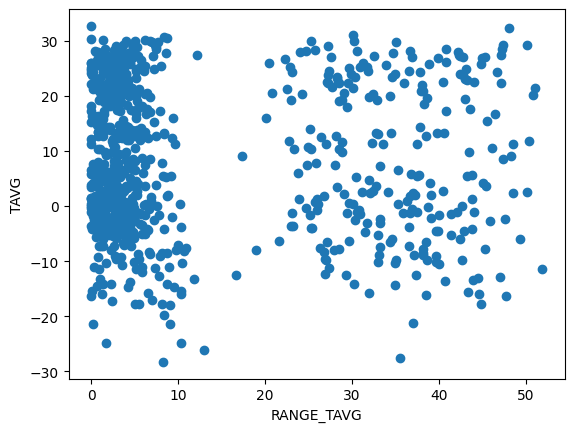

In [ ]:
plot_scatter()

## Scaling

In [ ]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

## Reshape data for LSTM [samples, time steps, features]

In [ ]:
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))



## Train-test split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=False)

# Define Attention Mechanism

In [ ]:
def attention_block(inputs):
    query = Dense(32)(inputs)
    key = Dense(32)(inputs)
    value = Dense(32)(inputs)
    attention_output = Attention()([query, key, value])
    return attention_output

# Modified Model with Attention

In [ ]:
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = Bidirectional(LSTM(64, return_sequences=True))(inputs)
x = Dropout(0.3)(x)
x = attention_block(x)
x = Bidirectional(LSTM(32, return_sequences=False))(x)
x = Dropout(0.3)(x)
x = Dense(16, activation='relu')(x)
outputs = Dense(1)(x)

In [ ]:
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mae')

# Train the model

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_val, y_val))

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


37/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12.7765

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 12.7690 - val_loss: 13.0386
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11.5309 - val_loss: 10.0178
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.1354 - val_loss: 5.0401
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5699 - val_loss: 4.3812
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.0328 - val_loss: 3.9016
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6044 - val_loss: 3.5237
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.0713 - val_loss: 3.1973
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.9164 - val_loss: 2.9406
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.4779 - val_loss: 2.8465
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.4463 - val_loss: 2.6217
Epoch 11/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.3654 - val_loss: 2.4035
Epoch 12/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.3408 - 

# Predict on validation set

In [ ]:
y_pred_val = model.predict(X_val)

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


# Calculate MAE on validation set

In [ ]:
mae_val = mean_absolute_error(y_val, y_pred_val)
print(f'Validation MAE: {mae_val:.4f}')

Validation MAE: 1.5468


# Preprocess the test data

In [ ]:
X_test = preprocess_data(test_data)
X_test_scaled = scaler.transform(X_test)
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Predict on the test set

In [ ]:
y_pred_test = model.predict(X_test_scaled)
y_pred_test = y_pred_test.round(2)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


# Create submission file

In [ ]:
submission = pd.DataFrame({
    'INDEX': test_data.index,
    'TAVG': y_pred_test.flatten()
})

submission.to_csv('submission.csv', index=False)

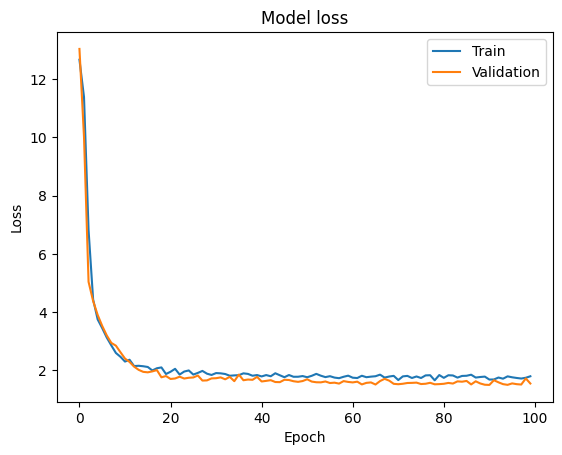

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()